In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
TEST_SIZE = 100
SELECTION_RATES = [0.1, 0.25, 0.5]
NUM_SPLITS = 5
ITERATIONS_PER_SPLIT = 20
PREDICTION_FILE = "predictions/heloc/model_predictions.csv"

In [3]:
full_df = pd.read_csv(PREDICTION_FILE)
NUM_MODELS = len(full_df.columns)-3
full_df.head()

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,y,idx,seed
0,0.800000,0.720000,0.880000,0.680000,0.68000,0.76000,0.760000,0.640000,0.720000,0.880000,1,3654,0
1,0.460438,0.469075,0.448139,0.439215,0.43974,0.44465,0.456582,0.421386,0.418838,0.432384,1,8612,0
2,0.200000,0.280000,0.160000,0.160000,0.28000,0.16000,0.120000,0.200000,0.080000,0.040000,0,2873,0
3,0.840000,0.760000,0.920000,0.880000,0.84000,0.88000,0.840000,0.920000,0.800000,0.920000,1,6983,0
4,0.480000,0.640000,0.440000,0.480000,0.56000,0.36000,0.400000,0.440000,0.720000,0.320000,0,2192,0


In [ ]:
def calculate_unique_allocations(k):
    # 1 -- What is the best precision?
    precision = {}
    for model in range(1, NUM_MODELS+1):
        allocation = df["p_"+str(model)].nlargest(k).index.to_list()
        precision[model] = int(df.loc[allocation, "y"].sum())
        # print(allocation, precision[model])
    best_precision = max(precision.values())

    # 2 -- Among models with best precision, calculate allocations    
    allocations = set()
    allocations_growth = []
    qualified_selections = []
    unqualified_selections = []
    for model in range(1, NUM_MODELS+1):
        if precision[model] != best_precision:
            if len(allocations_growth) == 0:
                allocations_growth.append(0)
            else:
                allocations_growth.append(allocations_growth[-1])
            continue
        
        allocation = df["p_"+str(model)].nlargest(k).index.to_list()

        selected = df.loc[allocation] 
        qualified_selections.append(selected[selected["y"]==1].index.to_list())
        unqualified_selections.append(selected[selected["y"]==0].index.to_list())
        
        allocation.sort()
        allocation = tuple(allocation)
        allocations.add(allocation)
        allocations_growth.append(len(allocations))

    qualified_selections = [item for sublist in qualified_selections for item in sublist]
    unqualified_selections = [item for sublist in unqualified_selections for item in sublist]
    qualified_count = dict(Counter(qualified_selections))
    unqualified_count = dict(Counter(unqualified_selections))
    
    return allocations_growth, best_precision, qualified_count.values(), unqualified_count.values()

## Homogenization: Unique Allocations with Equally-High Utility

In [5]:
results = []
allocations_growth = {}
qualified_count = {}
unqualified_count = {}
for rate in SELECTION_RATES:
    allocations_growth[rate] = []
    qualified_count[rate] = []
    unqualified_count[rate] = []

for split in range(NUM_SPLITS):
    print("Train-Test Split:", split)
    split_df = full_df[full_df["seed"]==split].copy()
    
    for i in tqdm(range(ITERATIONS_PER_SPLIT)):
        df = split_df.sample(n=TEST_SIZE, random_state=i)
    
        for rate in SELECTION_RATES:
            k = int(rate * len(df))
            allocations, precision, qc, uqc = calculate_unique_allocations(k)
            allocations_growth[rate].append(allocations)
            qualified_count[rate].append(qc)
            unqualified_count[rate].append(uqc)
            
            result = {"k": k, "n": TEST_SIZE, "k'": precision, "n'": df["y"].sum(), "allocations_found": max(allocations)}
            results.append(result)

Train-Test Split: 0


 50%|█████     | 10/20 [00:00<00:00, 91.24it/s]

[740, 622, 27, 295, 873, 590, 315, 765, 609, 863] {1: 8}
[873, 609, 969, 27, 859, 740, 765, 622, 399, 453] {1: 8, 2: 9}
[609, 622, 315, 399, 494, 800, 873, 451, 740, 351] {1: 8, 2: 9, 3: 9}
[873, 622, 740, 351, 609, 736, 315, 765, 295, 752] {1: 8, 2: 9, 3: 9, 4: 9}
[609, 622, 494, 453, 873, 27, 740, 295, 765, 590] {1: 8, 2: 9, 3: 9, 4: 9, 5: 9}
[27, 494, 765, 399, 859, 315, 451, 740, 295, 752] {1: 8, 2: 9, 3: 9, 4: 9, 5: 9, 6: 9}
[451, 765, 873, 351, 859, 453, 740, 295, 27, 494] {1: 8, 2: 9, 3: 9, 4: 9, 5: 9, 6: 9, 7: 9}
[453, 609, 969, 740, 873, 315, 494, 27, 765, 622] {1: 8, 2: 9, 3: 9, 4: 9, 5: 9, 6: 9, 7: 9, 8: 9}
[609, 752, 622, 453, 873, 27, 740, 451, 931, 494] {1: 8, 2: 9, 3: 9, 4: 9, 5: 9, 6: 9, 7: 9, 8: 9, 9: 9}
[873, 295, 765, 351, 399, 315, 740, 494, 863, 752] {1: 8, 2: 9, 3: 9, 4: 9, 5: 9, 6: 9, 7: 9, 8: 9, 9: 9, 10: 8}
[740, 622, 27, 295, 873, 590, 315, 765, 609, 863, 859, 736, 424, 453, 931, 494, 351, 451, 395, 416, 402, 752, 807, 837, 399] {1: 20}
[873, 609, 969, 27, 859

100%|██████████| 20/20 [00:00<00:00, 93.28it/s]


[609, 809, 662, 657, 862, 1016, 302, 60, 800, 323, 428, 314, 419, 790, 351, 944, 831, 395, 1024, 624, 261, 369, 245, 105, 802, 157, 1018, 38, 986, 967, 445, 383, 781, 387, 1042, 64, 531, 643, 23, 806, 876, 145, 981, 959, 755, 713, 578, 692, 886, 953] {1: 35, 2: 34, 3: 37}
[809, 657, 944, 831, 790, 428, 351, 862, 609, 662, 387, 1024, 967, 314, 383, 323, 261, 302, 1042, 1016, 38, 624, 64, 23, 959, 369, 245, 876, 531, 60, 713, 157, 801, 353, 692, 419, 812, 395, 1018, 643, 908, 961, 578, 843, 986, 807, 847, 1010, 145, 548] {1: 35, 2: 34, 3: 37, 4: 34}
[609, 657, 809, 314, 157, 944, 862, 662, 1024, 1042, 351, 831, 428, 624, 1016, 790, 369, 60, 387, 302, 807, 38, 701, 395, 64, 23, 419, 806, 959, 245, 781, 967, 800, 383, 323, 746, 843, 531, 261, 643, 548, 812, 105, 961, 713, 353, 981, 802, 1018, 692] {1: 35, 2: 34, 3: 37, 4: 34, 5: 37}
[657, 261, 862, 809, 662, 1042, 624, 23, 60, 1016, 383, 302, 609, 351, 802, 64, 790, 245, 157, 831, 38, 369, 967, 387, 1024, 428, 944, 843, 800, 531, 323, 1018

 50%|█████     | 10/20 [00:00<00:00, 95.48it/s]

[2015, 1695, 1362, 1905, 1579, 1864, 1888, 1462, 1101, 1826] {1: 9}
[1462, 1362, 2015, 1695, 1826, 1101, 1579, 1888, 1131, 1847] {1: 9, 2: 9}
[1888, 1695, 1462, 1617, 1362, 2015, 1430, 1905, 1684, 1826] {1: 9, 2: 9, 3: 8}
[1888, 1441, 1462, 1101, 1684, 1131, 1617, 1905, 1695, 1826] {1: 9, 2: 9, 3: 8, 4: 10}
[1341, 1617, 1362, 2015, 1441, 1462, 1101, 1905, 1695, 1888] {1: 9, 2: 9, 3: 8, 4: 10, 5: 9}
[1462, 1888, 1362, 2015, 1695, 1826, 1690, 1301, 1909, 1905] {1: 9, 2: 9, 3: 8, 4: 10, 5: 9, 6: 9}
[1462, 1579, 1888, 1826, 1101, 1695, 1684, 1441, 1362, 2015] {1: 9, 2: 9, 3: 8, 4: 10, 5: 9, 6: 9, 7: 9}
[1888, 1362, 1905, 1695, 1462, 1579, 1826, 1441, 1101, 1684] {1: 9, 2: 9, 3: 8, 4: 10, 5: 9, 6: 9, 7: 9, 8: 9}
[1695, 1462, 1362, 1579, 1826, 1131, 1905, 1707, 1831, 1888] {1: 9, 2: 9, 3: 8, 4: 10, 5: 9, 6: 9, 7: 9, 8: 9, 9: 9}
[1905, 2015, 1301, 1341, 1462, 1579, 1684, 1362, 1888, 1826] {1: 9, 2: 9, 3: 8, 4: 10, 5: 9, 6: 9, 7: 9, 8: 9, 9: 9, 10: 9}
[2015, 1695, 1362, 1905, 1579, 1864, 1888,

100%|██████████| 20/20 [00:00<00:00, 97.16it/s]


[1759, 1199, 1832, 1242, 1656, 1076, 1847, 1735, 1792, 1684] {1: 9, 2: 9, 3: 10, 4: 9, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10}
[1684, 1706, 2041, 1564, 1932, 1832, 1242, 1656, 1076, 1429] {1: 9, 2: 9, 3: 10, 4: 9, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10}
[1402, 1076, 1429, 1353, 1242, 1735, 1706, 1847, 1832, 1199, 1684, 2041, 1564, 1441, 1932, 1084, 1656, 1759, 1370, 1203, 1069, 1877, 1992, 1446, 1151] {1: 24}
[1706, 1199, 1441, 1402, 1847, 2041, 1242, 1684, 1877, 1353, 1076, 1832, 1735, 1746, 1564, 1792, 2025, 1203, 1465, 1932, 1759, 1429, 1230, 1433, 1387] {1: 24, 2: 21}
[1242, 1402, 1564, 1932, 1684, 1441, 1076, 1069, 1832, 1759, 1706, 1746, 1429, 1199, 1735, 1203, 1577, 1370, 1847, 1792, 1656, 1433, 2041, 1877, 1446] {1: 24, 2: 21, 3: 23}
[1353, 1441, 1706, 1242, 1684, 1564, 1759, 1076, 2041, 1932, 1735, 1832, 1199, 1151, 2088, 1847, 1429, 1656, 1402, 1072, 1746, 1465, 1084, 1433, 2025] {1: 24, 2: 21, 3: 23, 4: 21}
[1199, 1706, 1242, 1441, 1759, 1735, 2041, 1877, 1684, 1076, 1932, 183

 55%|█████▌    | 11/20 [00:00<00:00, 105.72it/s]

[2423, 2189, 2107, 2516, 2387, 2487, 3023, 2955, 2888, 2347] {1: 8}
[2189, 2660, 2487, 3023, 2955, 2888, 2741, 2996, 2585, 2387] {1: 8, 2: 9}
[2189, 3023, 2663, 2347, 2660, 2585, 2586, 2741, 2761, 2387] {1: 8, 2: 9, 3: 9}
[2965, 2189, 2955, 2761, 3023, 2660, 2554, 2494, 2423, 2347] {1: 8, 2: 9, 3: 9, 4: 8}
[3023, 2505, 2387, 2663, 2888, 2423, 2347, 2586, 2660, 2965] {1: 8, 2: 9, 3: 9, 4: 8, 5: 8}
[2119, 2189, 2741, 2585, 2423, 2660, 3023, 2586, 2107, 2955] {1: 8, 2: 9, 3: 9, 4: 8, 5: 8, 6: 8}
[2189, 2761, 2387, 2487, 2955, 2423, 2660, 2965, 2110, 2586] {1: 8, 2: 9, 3: 9, 4: 8, 5: 8, 6: 8, 7: 9}
[2189, 2586, 2724, 2347, 2119, 2487, 3032, 3023, 2955, 2741] {1: 8, 2: 9, 3: 9, 4: 8, 5: 8, 6: 8, 7: 9, 8: 9}
[2189, 2888, 2423, 2585, 2741, 2347, 3023, 2663, 2761, 2554] {1: 8, 2: 9, 3: 9, 4: 8, 5: 8, 6: 8, 7: 9, 8: 9, 9: 8}
[2586, 2189, 2107, 2741, 2423, 2554, 2110, 2347, 2119, 3023] {1: 8, 2: 9, 3: 9, 4: 8, 5: 8, 6: 8, 7: 9, 8: 9, 9: 8, 10: 8}
[2423, 2189, 2107, 2516, 2387, 2487, 3023, 2955, 

100%|██████████| 20/20 [00:00<00:00, 109.22it/s]


[2308, 2690, 2882, 2824, 2909, 2268, 2231, 3123, 2605, 2283, 2860, 3114, 2780, 2518, 2207, 2960, 2705, 2771, 2741, 2758, 2905, 2110, 2140, 2703, 2888] {1: 20, 2: 21, 3: 20, 4: 19, 5: 19, 6: 22, 7: 22, 8: 20}
[2888, 2268, 2231, 2207, 2780, 2705, 3123, 2308, 2741, 2263, 2703, 2771, 2909, 3109, 2860, 2824, 3034, 2429, 2110, 2120, 2518, 2690, 2992, 2107, 3114] {1: 20, 2: 21, 3: 20, 4: 19, 5: 19, 6: 22, 7: 22, 8: 20, 9: 19}
[2780, 2824, 2518, 2690, 2107, 3123, 2308, 2140, 2771, 3034, 2268, 2110, 2705, 2283, 2741, 2888, 2231, 2263, 2605, 2703, 2905, 2598, 2120, 2493, 2960] {1: 20, 2: 21, 3: 20, 4: 19, 5: 19, 6: 22, 7: 22, 8: 20, 9: 19, 10: 20}
[2268, 2824, 2140, 2882, 2308, 2705, 2207, 2905, 2703, 2107, 2888, 2231, 3123, 2263, 2518, 3034, 2110, 2120, 2860, 2493, 2376, 2780, 2605, 2741, 2758, 3003, 3092, 2909, 3029, 2264, 3114, 2603, 2283, 2771, 2690, 3109, 2598, 2891, 2429, 2625, 2245, 2953, 2372, 2968, 2992, 3036, 2932, 2960, 2884, 2106] {1: 37}
[2268, 2758, 2888, 2231, 2605, 2882, 2429, 21

  0%|          | 0/20 [00:00<?, ?it/s]

[3540, 3235, 3554, 3152, 3547, 3169, 3313, 3241, 3453, 3223] {1: 8}
[3878, 3799, 3169, 3235, 3554, 3540, 3709, 3793, 4011, 3547] {1: 8, 2: 10}
[3554, 3241, 3878, 3235, 3547, 3540, 3799, 3709, 3152, 3833] {1: 8, 2: 10, 3: 9}
[3878, 3547, 3554, 3709, 3799, 3833, 3241, 3453, 3770, 3629] {1: 8, 2: 10, 3: 9, 4: 9}
[3878, 3833, 3554, 3393, 3547, 3799, 3540, 3709, 3152, 3330] {1: 8, 2: 10, 3: 9, 4: 9, 5: 10}
[3878, 3522, 3709, 3547, 3934, 3799, 3453, 3235, 3313, 3223] {1: 8, 2: 10, 3: 9, 4: 9, 5: 10, 6: 8}
[3554, 3799, 3235, 3223, 3589, 3878, 3547, 3709, 3152, 3662] {1: 8, 2: 10, 3: 9, 4: 9, 5: 10, 6: 8, 7: 10}
[3540, 3878, 3709, 3934, 3223, 3547, 3522, 3554, 3833, 3241] {1: 8, 2: 10, 3: 9, 4: 9, 5: 10, 6: 8, 7: 10, 8: 8}
[3878, 3330, 3799, 3235, 3547, 3540, 3709, 3833, 4011, 3522] {1: 8, 2: 10, 3: 9, 4: 9, 5: 10, 6: 8, 7: 10, 8: 8, 9: 9}
[3152, 3799, 3878, 3554, 3540, 3169, 3709, 3934, 3235, 3223] {1: 8, 2: 10, 3: 9, 4: 9, 5: 10, 6: 8, 7: 10, 8: 8, 9: 9, 10: 10}
[3540, 3235, 3554, 3152, 3547

 40%|████      | 8/20 [00:00<00:00, 76.09it/s]

[3239, 3746, 3824, 3722, 3232, 3223, 3447, 3327, 3711, 4179] {1: 10}
[3865, 3863, 3447, 4011, 3920, 3173, 3239, 3711, 3329, 3824] {1: 10, 2: 9}
[3864, 3239, 3382, 3223, 3327, 3246, 3863, 3442, 3198, 4085] {1: 10, 2: 9, 3: 9}
[3239, 3722, 3824, 3654, 3904, 4179, 3920, 3524, 3442, 3327] {1: 10, 2: 9, 3: 9, 4: 10}
[3864, 3382, 4179, 3524, 3746, 3332, 3173, 3654, 3904, 3763] {1: 10, 2: 9, 3: 9, 4: 10, 5: 9}
[3654, 3863, 3239, 3824, 3901, 3722, 3382, 4147, 3223, 3746] {1: 10, 2: 9, 3: 9, 4: 10, 5: 9, 6: 9}
[3173, 3223, 3239, 3901, 3232, 3863, 3654, 3722, 3711, 3904] {1: 10, 2: 9, 3: 9, 4: 10, 5: 9, 6: 9, 7: 9}
[3654, 3239, 3722, 3223, 3382, 3824, 3746, 3447, 3901, 3327] {1: 10, 2: 9, 3: 9, 4: 10, 5: 9, 6: 9, 7: 9, 8: 10}
[3746, 3654, 3904, 3524, 3198, 3239, 3442, 3447, 4179, 3382] {1: 10, 2: 9, 3: 9, 4: 10, 5: 9, 6: 9, 7: 9, 8: 10, 9: 10}
[3239, 3654, 3864, 3524, 3863, 3442, 3746, 4179, 3382, 3824] {1: 10, 2: 9, 3: 9, 4: 10, 5: 9, 6: 9, 7: 9, 8: 10, 9: 10, 10: 9}
[3239, 3746, 3824, 3722, 32

100%|██████████| 20/20 [00:00<00:00, 85.56it/s]


[3152, 3755, 3934, 3858, 4041, 3751, 3564, 3955, 4160, 3643, 4169, 3328, 3403, 3329, 3865, 4086, 3214, 3463, 3327, 3802, 4080, 3352, 3973, 3528, 3186] {1: 20, 2: 21, 3: 19, 4: 22, 5: 21, 6: 23, 7: 18, 8: 21, 9: 20, 10: 21}
[3152, 3858, 3955, 4086, 3186, 3934, 3751, 3327, 3403, 3329, 4041, 3974, 4160, 3328, 3999, 3214, 3865, 3930, 3804, 3802, 3755, 3463, 3817, 4080, 3643, 4169, 4165, 3629, 3749, 3309, 3564, 3962, 3528, 3534, 3649, 3352, 3671, 3973, 3341, 3644, 4082, 3216, 4006, 3849, 3784, 3418, 3736, 3595, 3166, 3875] {1: 36}
[4160, 3858, 3973, 3865, 3755, 3152, 3186, 3955, 3352, 3629, 3751, 3329, 3802, 3934, 3327, 3962, 4169, 4086, 3463, 3341, 3817, 4165, 3328, 3564, 3930, 4080, 3804, 3643, 3403, 3214, 3679, 4075, 3528, 3649, 3784, 3999, 3736, 3534, 3671, 3202, 3730, 3166, 4041, 4138, 3539, 3251, 3826, 3986, 4014, 3713] {1: 36, 2: 38}
[3955, 3152, 3751, 4041, 3327, 3629, 3934, 3973, 3564, 3804, 4080, 3974, 4160, 3649, 4086, 3858, 3186, 3341, 3403, 3755, 3671, 4169, 3849, 3643, 3328, 3

  0%|          | 0/20 [00:00<?, ?it/s]

[4969, 4199, 4500, 4359, 5047, 4991, 4437, 4326, 4646, 4949] {1: 8}
[4678, 4199, 4597, 4437, 4479, 4500, 4838, 4932, 4535, 4326] {1: 8, 2: 9}
[4437, 4500, 5153, 4677, 4838, 4199, 4991, 4479, 4949, 4678] {1: 8, 2: 9, 3: 7}
[4500, 4437, 4991, 4838, 4597, 4211, 4593, 5047, 4359, 4326] {1: 8, 2: 9, 3: 7, 4: 9}
[4500, 4991, 5026, 4936, 4437, 4326, 4677, 4479, 4600, 5047] {1: 8, 2: 9, 3: 7, 4: 9, 5: 8}
[4500, 4437, 4535, 4597, 5186, 4932, 4359, 4326, 4838, 4991] {1: 8, 2: 9, 3: 7, 4: 9, 5: 8, 6: 9}
[4437, 4500, 4991, 4646, 4838, 4678, 5153, 4326, 4839, 4199] {1: 8, 2: 9, 3: 7, 4: 9, 5: 8, 6: 9, 7: 8}
[4838, 4500, 4678, 4199, 5047, 5161, 4991, 4597, 4677, 4984] {1: 8, 2: 9, 3: 7, 4: 9, 5: 8, 6: 9, 7: 8, 8: 10}
[4437, 4678, 4500, 4359, 4326, 4838, 4600, 5047, 5161, 4593] {1: 8, 2: 9, 3: 7, 4: 9, 5: 8, 6: 9, 7: 8, 8: 10, 9: 9}
[4500, 4437, 5026, 4590, 4359, 4479, 4839, 5047, 4969, 4259] {1: 8, 2: 9, 3: 7, 4: 9, 5: 8, 6: 9, 7: 8, 8: 10, 9: 9, 10: 8}
[4969, 4199, 4500, 4359, 5047, 4991, 4437, 432

 50%|█████     | 10/20 [00:00<00:00, 92.59it/s]

[4500, 4437, 4535, 4597, 5186, 4932, 4359, 4326, 4838, 4991, 4590, 5153, 5026, 4646, 4677, 4479, 4678, 5047, 4969, 4199, 5161, 4690, 4788, 4593, 4600, 4478, 4936, 4828, 4949, 4984, 4239, 4675, 5088, 5099, 4953, 4259, 4198, 4980, 4964, 4211, 4839, 5124, 4568, 4813, 4583, 4515, 4281, 5097, 4879, 4499] {1: 35, 2: 35, 3: 36, 4: 34, 5: 36, 6: 35}
[4437, 4500, 4991, 4646, 4838, 4678, 5153, 4326, 4839, 4199, 4479, 4593, 5026, 4600, 5186, 5047, 5161, 4535, 4980, 4677, 4211, 4949, 4590, 4969, 5124, 4932, 4359, 4828, 4597, 4984, 5183, 4439, 5099, 4748, 4568, 4755, 4936, 4259, 4198, 4478, 4690, 5021, 5069, 4675, 5088, 5097, 4658, 4239, 4833, 4463] {1: 35, 2: 35, 3: 36, 4: 34, 5: 36, 6: 35, 7: 34}
[4838, 4500, 4678, 4199, 5047, 5161, 4991, 4597, 4677, 4984, 4828, 4437, 5186, 4535, 5153, 4479, 4600, 4936, 4980, 4359, 4969, 4326, 4646, 4675, 4839, 4593, 5026, 4259, 5124, 5088, 4499, 4439, 4964, 4949, 5099, 4590, 4932, 4239, 4690, 5021, 4583, 4637, 4515, 4198, 4658, 4833, 4568, 5069, 4478, 5097] {1: 

100%|██████████| 20/20 [00:00<00:00, 82.25it/s]

[4801, 4976, 4449, 4574, 4199, 4355, 4400, 4797, 4697, 4803, 5128, 4965, 4468, 4323, 4375, 4356, 4374, 4921, 4690, 5019, 5206, 5132, 4352, 4232, 4509] {1: 18, 2: 19}
[4965, 4801, 4697, 5060, 4199, 4468, 4323, 4374, 4976, 4803, 4980, 4574, 4983, 4797, 4232, 5126, 5128, 4198, 4355, 4921, 4907, 4690, 4997, 5008, 4356] {1: 18, 2: 19, 3: 17}
[4449, 4574, 4803, 4468, 4400, 4797, 5060, 4976, 4801, 4697, 5032, 4199, 4965, 4921, 5206, 4374, 4352, 4232, 4833, 4997, 5128, 4297, 5211, 4980, 4355] {1: 18, 2: 19, 3: 17, 4: 17}
[4697, 4801, 4797, 4965, 4803, 4449, 4574, 5128, 5032, 5060, 4323, 4355, 4232, 4976, 4199, 4468, 4983, 4374, 4980, 4297, 4400, 4921, 4997, 4212, 4352] {1: 18, 2: 19, 3: 17, 4: 17, 5: 18}
[4797, 4449, 4801, 4374, 4574, 4965, 4921, 4976, 4323, 5032, 4697, 4232, 4803, 4997, 5128, 4356, 4355, 5001, 5206, 4400, 4199, 4690, 4468, 4352, 4375] {1: 18, 2: 19, 3: 17, 4: 17, 5: 18, 6: 18}
[4797, 4801, 4400, 4697, 4976, 4803, 4374, 4449, 4199, 4468, 4997, 4980, 4983, 4574, 5032, 4921, 435

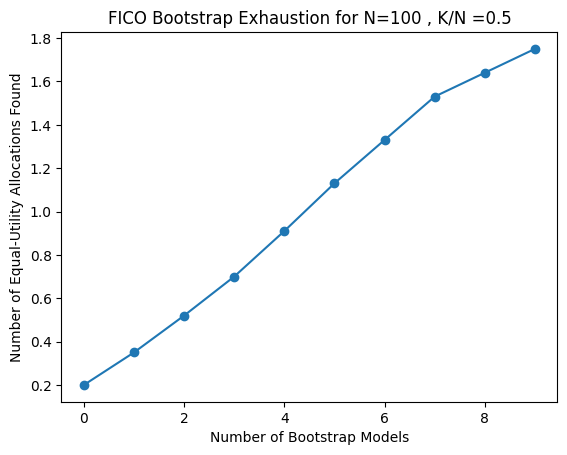

In [12]:
k_n = 0.50
data = np.array(allocations_growth[k_n])
data = np.mean(data, axis=0)

x = np.arange(len(data))
plt.plot(x, data, marker='o')

plt.title('Obermeyer for N='+str(TEST_SIZE)+' , K/N ='+str(k_n))
plt.xlabel('Number of Bootstrap Models')
plt.ylabel('Number of Equal-Utility Allocations Found')

plt.show()

## Individual Fairness: Selection Frequency

In [13]:
for rate in SELECTION_RATES:
    qualified_count[rate] = [item for sublist in qualified_count[rate] for item in sublist]
    unqualified_count[rate] = [item for sublist in unqualified_count[rate] for item in sublist]

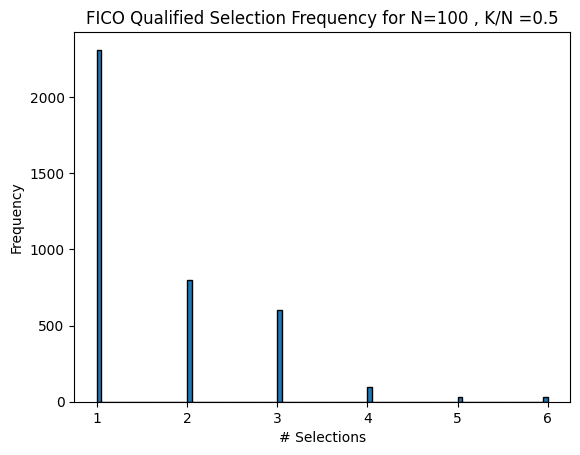

In [14]:
k_n = 0.50
plt.hist(qualified_count[k_n], bins=100, edgecolor='black')

plt.xlabel('# Selections')
plt.ylabel('Frequency')
plt.title('FICO Qualified Selection Frequency for N='+str(TEST_SIZE)+' , K/N ='+str(k_n))
plt.show()

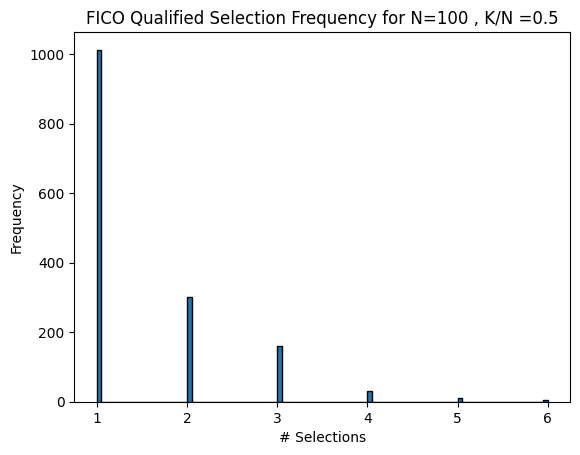

In [15]:
k_n = 0.50
plt.hist(unqualified_count[k_n], bins=100, edgecolor='black')

plt.xlabel('# Selections')
plt.ylabel('Frequency')
plt.title('FICO Qualified Selection Frequency for N='+str(TEST_SIZE)+' , K/N ='+str(k_n))
plt.show()